# Предсказание категории текста

Исходный датасет:
    
https://www.kaggle.com/competitions/quora-insincere-questions-classification/data?select=train.csv

In [117]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [118]:
df = pd.read_csv("train.csv").iloc[:1300000]
df.head(3)

,qid,text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0


Посмотрим на распределение классов:

In [119]:
df['target'].value_counts()

0    1219557
1      80443
Name: target, dtype: int64

In [120]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['target'], random_state=0)

In [121]:
# соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

# max_features=20000. для обработки полного датасета нужно 1.5 ТБ ОЗУ

# При обработке текста оказалось, что у сообщений в классе 1 явно больше букв и слов.
# Это можно использовать для дальнейшего предсказания
pipeline = Pipeline([('title_selector', FeatureSelector(column='text')), 
                     ('title_tfidf', TfidfVectorizer(stop_words='english',
                                                     ngram_range=(1,3),
                                                     max_features=None, 
                                                     min_df=0.001, 
                                                     max_df=0.20)), 
                     ('clf', LogisticRegression())])

- FeatureSelector - выбирает столбец Title и передает его значения на следующий шаг
- TfidfVectorizer - векторизует текст (поле Title)
- LogisticRegression - наш бинарный классификатор, который обучается на результатах предыдущих шагов и разметке (их мы передадим уже при обучении)

In [122]:
# обучим
pipeline.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('title_selector', FeatureSelector(column='text')),
                ('title_tfidf',
                 TfidfVectorizer(max_df=0.2, min_df=0.001, ngram_range=(1, 3),
                                 stop_words='english')),
                ('clf', LogisticRegression())])

In [123]:
# прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.0103762 , 0.00355558, 0.12375584, 0.01073603, 0.02977528,
       0.05841355, 0.19117339, 0.06712206, 0.01102851, 0.00036944])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

### Рассчитаем Precision, Recall, F_score

In [124]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [125]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold = {thresholds[ix]}')
print(f'F-Score = {fscore[ix]}')
print(f'Precision = {precision[ix]}')
print(f'Recall = {recall[ix]}')

Best Threshold = 0.22996919759062198
F-Score = 0.4982790324862087
Precision = 0.4756503735709785
Recall = 0.5231683168316832


Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

Отрисуем матрицу ошибок для нашего примера

In [126]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[293150  11650]
 [  9633  10567]]


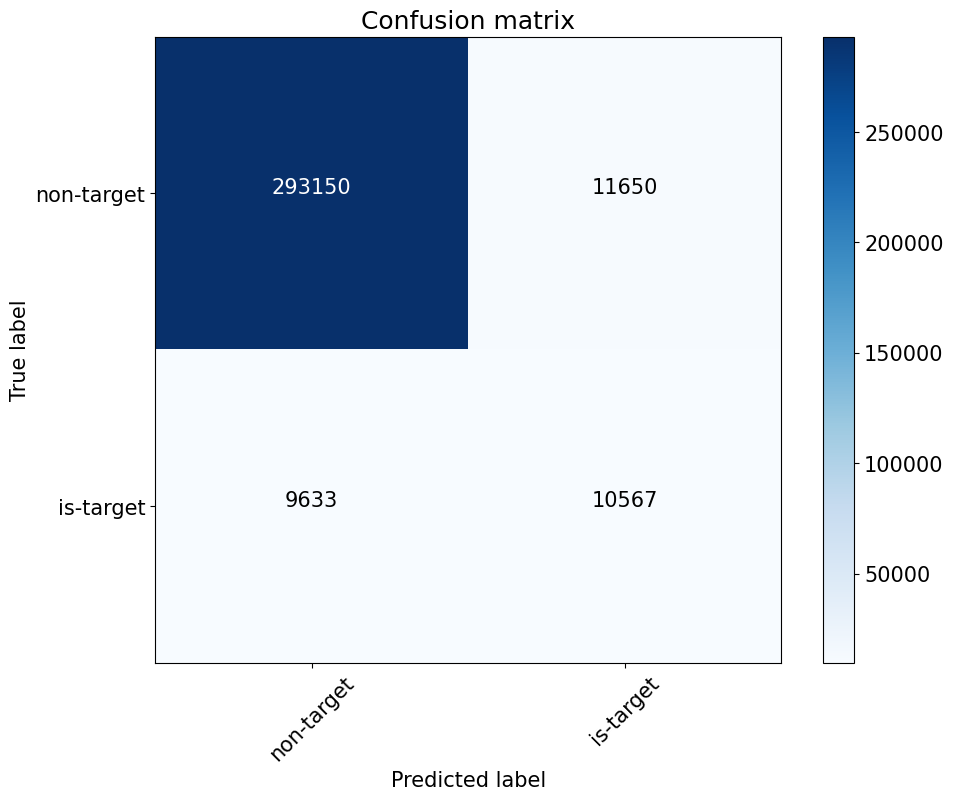

In [127]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size': 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix,
                      classes=['non-target', 'is-target'],
                      title='Confusion matrix')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.96      0.96    304800
           1       0.48      0.52      0.50     20200

    accuracy                           0.93    325000
   macro avg       0.72      0.74      0.73    325000
weighted avg       0.94      0.93      0.94    325000



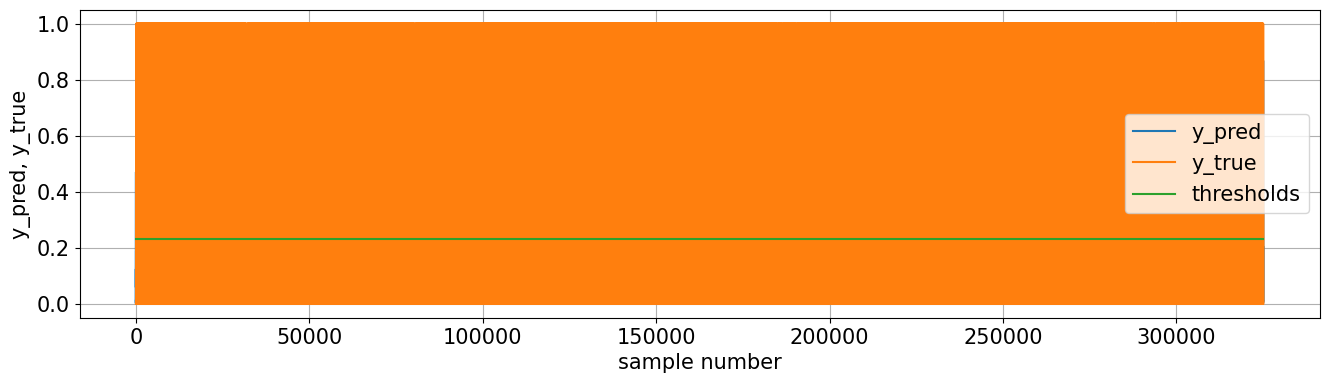

In [128]:
print(classification_report(y_test, preds >= thresholds[ix]))

plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('sample number')
plt.ylabel('y_pred, y_true')

plt.plot(preds, label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0, len(y_test.values.tolist())],
         [thresholds[ix], thresholds[ix]],
         label='thresholds')

plt.legend()
plt.show()

In [ ]:
# Какие слова попали в выборку, какое оказали влияние:

vec = pipeline[1]

vec_fit_tr = vec.fit_transform(X_train['text'])

tfidf = vec_fit_tr.todense()

dp = pd.DataFrame(tfidf, columns=vec.get_feature_names_out()).T

dp = pd.DataFrame([dp.mean(1), dp.max(1)], index=['mean', 'max']).T

dp.sort_values(by=['mean'], ascending=False)